In [42]:
import os
import fnmatch
import itertools
from datetime import datetime
from pathlib import Path

import geowombat as gw
from geowombat.models import CloudClassifier

import geopandas as gpd
import numpy as np
import cv2
import numba as nb
from skimage.exposure import rescale_intensity
import sklearn_crfsuite
from sklearn.preprocessing import LabelEncoder
from affine import Affine
from tqdm import tqdm
import matplotlib.pyplot as plt

## Functions

In [43]:
# str_to_int_dict = dict(n=0, a=1, g=1, t=1, u=1, b=1, w=2, c=3, s=4, h=5)
# str_to_int_dict = dict(n=0, a=1, g=2, t=3, u=4, b=5, w=6, c=7, s=8, h=9)
str_to_int_dict = dict(n=0, l=1, u=2, w=3, c=4, s=5, h=6)

int_to_str_dict = dict()
for k, v in str_to_int_dict.items():
    int_to_str_dict[v] = k

In [44]:
def pred_to_labels(model_pred):
    
    return np.array([[[ps['l'] if 'l' in ps else 0, 
                       ps['u'] if 'u' in ps else 0, 
                       ps['w'] if 'w' in ps else 0, 
                       ps['c'] if 'c' in ps else 0, 
                       ps['s'] if 's' in ps else 0] for ps in p] for p in model_pred], dtype='float64')

In [45]:
def label_decoder(label):
    return int_to_str_dict[label]


@nb.jit
#def sample_to_dict(tsp, fsp, bsp, sdistf, sdistb):
def sample_to_dict(tsp, ndvi):
    
    """
    Args:
        tsp (1d)
        fsp (1d)
        bsp (1d)
        sdist (1d)
    """

    nt = len(tsp)
    
    tlab = np.empty(nt+1, dtype=object)
    #flab = tlab.copy()
    #blab = tlab.copy()
    
    #tval = np.zeros((nt*3)+2, dtype='float64')
    tval = np.zeros(nt+1, dtype='float64')
    
    for r in range(0, nt):
        
        tlab[r] = str(r+1).encode('utf-8')
        
        #flab[r] = 'b{:d}_f'.format(r+1)
        #blab[r] = 'b{:d}_b'.format(r+1)
        
        tval[r] = tsp[r]
        #tval[r+nt] = fsp[r]
        #tval[r+int(nt*2)] = bsp[r]
    
    tlab[r+1] = 'ndvi'.encode('utf-8')
    tval[r+1] = ndvi
    
    #tval[-2] = sdistf
    #tval[-1] = sdistb
    
    #return dict(zip(tlab.tolist() + flab.tolist() + blab.tolist() + ['sdistf', 'sdistb'], tval))
    #return dict(zip(tlab.tolist() + ['sdistf', 'sdistb'], tval))
    return dict(zip(tlab.tolist(), tval))


def _ndvi(red, nir):
    return (nir - red) / (nir + red)
    
    
SENSOR_BANDS = dict(l7=dict(blue=0,
                            green=1,
                            red=2,
                            nir=3,
                            swir1=4,
                            swir2=5),
                    s2l7=dict(blue=0,
                              green=1,
                              red=2,
                              nir=3,
                              swir1=4,
                              swir2=5))    

@nb.jit
def array_to_dict(sensor, *args):
    
    """
    Converts an array sample to a CRF features
    """
    
    nargs = len(args)
    feas = list()
    
    red_idx = SENSOR_BANDS[sensor]['red']
    nir_idx = SENSOR_BANDS[sensor]['nir']
    
    for si in range(0, nargs):
        
        tsamp = args[si]*0.0001
        
        ndvi = _ndvi(tsamp[red_idx], tsamp[nir_idx])
        
#         # forward
#         if si < nargs-1:
#             fsamp = args[si+1]*0.0001 - tsamp
#             sdistf = spectral_dist(tsamp, args[si+1]*0.0001)
#         else:
#             fsamp = np.zeros(tsamp.shape[0], dtype='float64')
#             sdistf = 0.0
            
#         # backward
#         if si == 0:
#             bsamp = np.zeros(tsamp.shape[0], dtype='float64')
#             sdistb = 0.0
#         else:
#             bsamp = tsamp - args[si-1]*0.0001
#             sdistb = spectral_dist(args[si-1]*0.0001, tsamp)
        
        #feas.append(sample_to_dict(tsamp, fsamp, bsamp, sdistf, sdistb))
        feas.append(sample_to_dict(tsamp, ndvi))
            
    return feas

## Extract data

In [46]:
# Landsat 8
# rpath = Path('/media/jcgr/data/imagery/google/p225r083/brdf')
# vpath = Path('/media/jcgr/data/imagery/google/training/p225r83.shp')

# Sentinel 2
rpath = Path('/scratch/rsc8/hardtkel/rapidfires/LW')
vpath = Path('/scratch/rsc4/graesser/temp/s2/training/s2_training.shp')

df = gpd.read_file(vpath.as_posix())

df.head()

,id,label,image,geometry
0,None,s,t55kdu/cemsre_t55kdu_20171210_abbm5,"POLYGON ((507064.648 7815065.614, 507064.648 7..."
1,None,s,t55kdu/cemsre_t55kdu_20171210_abbm5,"POLYGON ((506948.752 7814128.218, 506948.752 7..."
2,None,s,t55kdu/cemsre_t55kdu_20171210_abbm5,"POLYGON ((504307.000 7812038.678, 504307.000 7..."
3,None,s,t55kdu/cemsre_t55kdu_20171210_abbm5,"POLYGON ((504047.938 7814997.439, 504047.938 7..."
4,None,s,t55kdu/cemsre_t55kdu_20171210_abbm5,"POLYGON ((504361.540 7816885.866, 504361.540 7..."


In [47]:
image_ext = '.img'

minrow = 1e9
mincol = 1e9

X_data = list()
y_data = list()

df = df.replace(to_replace='u', value='l')

# le = LabelEncoder()
# le.fit(df.label.values)
# df['label_value'] = le.transform(df.label.values)

for row in tqdm(df.itertuples(index=True, name='Pandas'), total=df.shape[0]):
    
    with gw.open(rpath.joinpath(row.image + image_ext).as_posix(), chunks=512) as ds:
        
        clip = gw.clip(ds, 
                       df, 
                       query="index == {:d}".format(row.Index), 
                       mask_data=False)
        
        subset = clip.data.compute()
        minrow = min(subset.shape[1], minrow)
        mincol = min(subset.shape[2], mincol)
        X_data.append(subset)
        y_data.append(row.label)
    
X_data = np.array([d[:, :minrow, :mincol] for d in X_data], dtype='float64')

100%|██████████| 189/189 [00:33<00:00,  5.65it/s]


In [48]:
X_data.shape

(189, 6, 7, 8)

### Augment the data

In [49]:
n_iter = 20
sensor = 's2l7'

max_rand_length = 20

ntime, nbands, nrows, ncols = X_data.shape
features = list()

X = list()
y = list()

for iter_ in range(0, n_iter):

    for a in tqdm([['u', 'w', 'h'], ['u', 'l', 'h']], total=2):

        Xd = list()
        yd = list()

        idx_null = np.array([ij for ij, cl in enumerate(y_data) if cl not in a], dtype='int64')

        ntime_null = idx_null.shape[0]

        low = np.random.randint(0, high=int(ntime_null/2))
        high = np.random.randint(low+2, high=ntime_null)
        idx_random = np.array([i + 1 for i in range(low, high)], dtype='int64')

        n_rand = min(len(idx_random), max_rand_length)

        for i in range(0, n_rand):

            # Get a random subset of temporal indices
            idx = idx_null[np.random.choice(idx_random, size=n_rand, replace=False)]

            # Transpose each temporal state --> samples x features
            Xd_ = [dlayer.transpose(1, 2, 0).reshape(nrows*ncols, nbands) for dlayer in X_data[idx]]

            # Flatten the data from [time x features x rows x columns] --> [s1, s2, ..., sn]
            # len(Xd_) = n samples
            # len(Xd_[0]) = n time
            Xd_ = [array_to_dict(sensor, *[Xd_[j][i] for j in range(0, idx.shape[0])]) for i in range(0, nrows*ncols)]

            # len(y_) = n samples
            # len(y_[0]) = n time        
            y_ = [np.array(y_data)[idx].tolist() for i in range(0, nrows*ncols)]

            Xd += Xd_
            yd += y_

        # time series of len(idx) x n_rand x n_rand
        #Xd = np.vstack(Xd)
        #niter = Xd.shape[0]

    #     Xd = [dlayer.transpose(1, 2, 0).reshape(nrows*ncols, nbands) for dlayer in Xd]
    #     Xd = [array_to_dict(*[Xd[j][i] for j in range(0, niter)]) for i in range(0, nrows*ncols)]

    #     yd = list(itertools.chain(*yd))
    #     yd = [[y_ for y_ in yd] for i in range(0, nrows*ncols)]

        X += Xd
        y += yd

100%|██████████| 2/2 [00:02<00:00,  1.40s/it]


In [50]:
print('Number of random arrangements:', n_iter)
print('Number of samples:', nrows*ncols)
print('Number of random arrangements x n samples:', len(X))
print(len(X))
print(len(y))

Number of random arrangements: 20
Number of samples: 56
Number of random arrangements x n samples: 40152
40152
40152


## Model

In [51]:
# Gradient descent using the limited-memory BFGS method (with L1 and L2 regularization)
model = CloudClassifier(algorithm='lbfgs', 
                        c1=0.001,
                        c2=0.001,
                        max_iterations=1000,
                        num_memories=20,
                        epsilon=0.01,
                        delta=0.01,
                        period=20,
                        linesearch='MoreThuente',  # 'MoreThuente' 'Backtracking' 'StrongBacktracking'
                        max_linesearch=20,
                        all_possible_states=True,
                        all_possible_transitions=True,
                        verbose=False)

In [52]:
%%time

model.fit(X, y)

CPU times: user 39.2 s, sys: 148 ms, total: 39.4 s
Wall time: 39.4 s


In [53]:
model.to_file('/scratch/rsc4/graesser/temp/clouds.model', overwrite=True)

### Testing

In [ ]:
X_data.shape

In [ ]:
features = [tlayer.transpose(1, 2, 0).reshape(nrows*ncols, nbands) for tlayer in X_data]
features = [array_to_dict(*[features[j][i] for j in range(0, ntime)]) for i in range(0, nrows*ncols)]

In [ ]:
pred = pred_to_labels(model.predict_marginals(features))
pred = pred.transpose(1, 2, 0).reshape(ntime, pred.shape[2], nrows, ncols)

In [ ]:
pred.shape

In [ ]:
time_index = 0
classes = ['l', 'u', 'c', 's', 'h']

print('True:', y_data[time_index])
print('')

max_proba = 0.0

for j in range(0, len(classes)):
    
    class_proba_mean = pred[time_index][j].mean()
    
    print('Predicted {}:'.format(classes[j]), class_proba_mean)
    
    if class_proba_mean > max_proba:
        max_proba = class_proba_mean
        max_class = classes[j]
        
print('Max:', max_class, max_proba)

## Predict on an image

In [71]:
rpath_pred = rpath.joinpath('t55kcu')
rpath_pred

PosixPath('/scratch/rsc8/hardtkel/rapidfires/LW/t55kcu')

In [72]:
date_pos = 2
wildcard = '*_abbm5.img'

# date_pos = 3
# wildcard = '*.tif'

filenames = fnmatch.filter(os.listdir(rpath_pred.as_posix()), wildcard)

filename_dict = dict()
for fn in filenames:
    filename_dict[fn.split('_')[date_pos]] = fn

sorted_names = list(zip(*sorted(filename_dict.items())))
filenames = [rpath_pred.joinpath(fn).as_posix() for fn in list(sorted_names[1])]
time_names = [datetime.strptime(t, '%Y%m%d') for t in list(sorted_names[0])]

In [75]:
s = 512
t = 8
x = 369815.045
y = 7824527.346

with gw.config.update(sensor='s2l7'):
    
    with gw.open(filenames[:t], 
                 time_names=time_names[:t],
                 chunks=512,
                 num_threads=8) as ds:
        
        dss = gw.subset(ds, left=x, top=y, rows=s, cols=s)
        
        test = dss.astype('float64').data.compute()

In [76]:
model = CloudClassifier()
model.from_file('/scratch/rsc4/graesser/temp/clouds.model')
pred = model.predict_probas(test, 's2l7')

In [77]:
# ntime, nbands, nrows, ncols = test.shape

In [78]:
# features = np.ascontiguousarray([tlayer.transpose(1, 2, 0).reshape(nrows*ncols, nbands) for tlayer in test], dtype='float64')

In [79]:
# features = time_to_crffeas(features,
#                            's2l7',
#                            ntime,
#                            nrows,
#                            ncols)

In [80]:
# features = [tlayer.transpose(1, 2, 0).reshape(nrows*ncols, nbands) for tlayer in test]
# features = [array_to_dict(*[features[j][i] for j in range(0, ntime)]) for i in range(0, nrows*ncols)]

In [81]:
# pred = pred_to_labels(model.predict_marginals(features))
# pred = pred.transpose(1, 2, 0).reshape(ntime, pred.shape[2], nrows, ncols)

In [82]:
pred.shape

(8, 5, 512, 512)

---

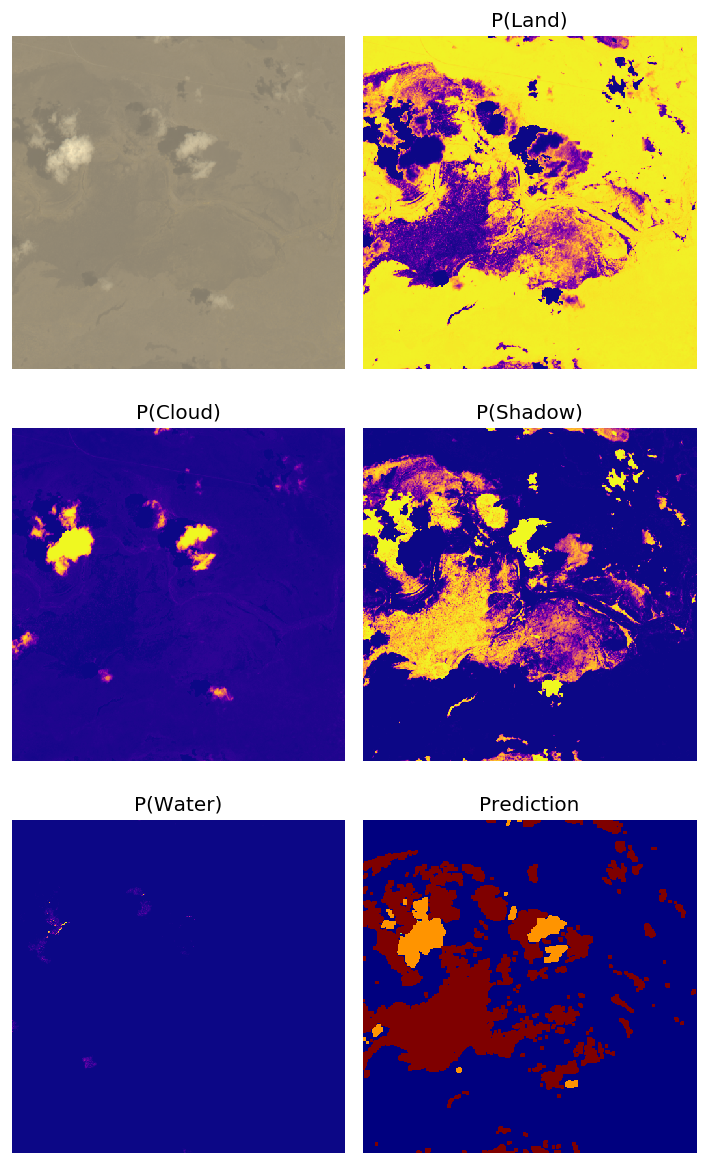

In [94]:
fig, axes = plt.subplots(3, 2, dpi=120, figsize=(6, 10))

pthresh = 0.7

tplot = 2
cplot = 4

classes = ['l', 'u', 'w', 'c', 's']

# Time n, mean over bands
rgb = test[tplot][:3].copy()
for i in range(0, 3):
    rgb[i] = rescale_intensity(rgb[i], out_range=(np.percentile(rgb[i], 5), np.percentile(rgb[i], 95)))
rgb = rgb.transpose(1, 2, 0)
rgb = rgb[..., ::-1]
rgb /= rgb.max()

axes[0][0].imshow(rgb)
axes[0][0].axis('off')

# Time n, predicted probabilities for class k
axes[0][1].imshow(pred[tplot][classes.index('l')], vmin=0, vmax=1, cmap='plasma')
axes[0][1].set_title('P(Land)')
axes[0][1].axis('off')

axes[1][0].imshow(pred[tplot][classes.index('c')], vmin=0, vmax=1, cmap='plasma')
axes[1][0].set_title('P(Cloud)')
axes[1][0].axis('off')

axes[1][1].imshow(pred[tplot][classes.index('s')], vmin=0, vmax=1, cmap='plasma')
axes[1][1].set_title('P(Shadow)')
axes[1][1].axis('off')

axes[2][0].imshow(pred[tplot][classes.index('w')], vmin=0, vmax=1, cmap='plasma')
axes[2][0].set_title('P(Water)')
axes[2][0].axis('off')

pred_int = pred[tplot].argmax(axis=0) + 1

# pred_int = np.where((amax == classes.index('c')) & (pred[tplot][classes.index('c')] > pthresh), 1, 
#                     np.where((amax == classes.index('s')) & (pred[tplot][classes.index('s')] > pthresh), 2, 0))

kernel_cross = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype='uint8')
kernel_square = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]], dtype='uint8')
# pred_int = cv2.morphologyEx(np.uint8(pred_int), cv2.MORPH_OPEN, kernel)
# pred_int = cv2.dilate(np.uint8(pred_int), kernel, iterations=2)
pred_int = cv2.erode(np.uint8(pred_int), kernel_square, iterations=1)
pred_int = cv2.dilate(np.uint8(pred_int), kernel_square, iterations=2)

axes[2][1].imshow(pred_int, vmin=1, vmax=5, cmap='jet')
axes[2][1].set_title('Prediction')
axes[2][1].axis('off')

plt.tight_layout()

plt.show()

## Download PlanetScope data

In [ ]:
# download_data('/scratch/rsc4/graesser/temp/planet',
#               '/export/home/graesserj/code/python/github/planet/tsplanet/geojson/qld.geojson',
#               '2019-08-01', 
#               '2019-08-10',
#               cloud_cover=0.8,
#               api_key='des')

## Extract samples from training AOIs

In [ ]:
def setup_names(grid, filenames):
    
    rpath_dict = {'t55jel': '/scratch/rsc8/hardtkel/biocondition/biocondition/layers/sentinel/{}'.format(grid),
                  't56jkt': '/scratch/rsc8/hardtkel/biocondition/biocondition/layers/sentinel/{}'.format(grid),
                  't55kcu': '/scratch/rsc8/hardtkel/rapidfires/LW/{}'.format(grid),
                  'l8': '/media/jcgr/data/imagery/google/p225r083/brdf'}
    
    NameInfo = namedtuple('NameInfo', 'rasters vector, time_names')
    
    #vector_dir = Path('/scratch/rsc4/graesser/temp/s2/training')
    vector_dir = Path('/media/jcgr/data/imagery/google/training')
    
    image_dir = Path(rpath_dict[grid])
    
    filename_dict = dict()
    for fn in filenames:
        filename_dict[fn.split('_')[2]] = fn

    sorted_names = list(zip(*sorted(filename_dict.items())))
    
    filenames = list(sorted_names[1])
    
    time_names = [datetime.strptime(t, '%Y%m%d') for t in list(sorted_names[0])]
    
    rasters = [image_dir.joinpath(fn).as_posix() for fn in filenames]
    vector = vector_dir.joinpath('{}.shp'.format(grid)).as_posix()
    
    return NameInfo(rasters=rasters, vector=vector, time_names=time_names)

In [ ]:
filenames = fnmatch.filter(os.listdir(image_dir.as_posix()), '*.tif')

filename_dict = dict()
for fn in filenames:
    filename_dict[fn.split('_')[3]] = fn

In [ ]:
sorted_names = list(zip(*sorted(filename_dict.items())))

In [ ]:
filenames = list(sorted_names[1])

In [ ]:
time_names = [datetime.strptime(t, '%Y%m%d') for t in list(sorted_names[0])]

In [ ]:
rasters = [image_dir.joinpath(fn).as_posix() for fn in filenames]
vector = vector_dir.joinpath('p225r83.shp').as_posix()

### Plot the intersection

In [ ]:
# with gw.config.update(ref_image=rasters[0], 
#                       ref_res=(10, 10), 
#                       sensor='planetscope'):
    
#     with gw.open(rasters,
#                  time_names=time_names,
#                  how='intersection',
#                  chunks=512) as ds:
        
#         dss = ds.mean(dim='time')
#         dss.attrs = ds.attrs
#         print(ds)
        
#         #dss.gw.imshow(band_names=['red', 'green', 'blue'], nodata=0, robust=True)

### Extract samples

#### Split samples

In [ ]:
df = gpd.read_file(vector)

df['class_len'] = df['class'].str.len()
df['int_class'] = df.apply(str_to_int, axis=1)
out = df['int_class'].str.split(',', expand=True)

df_list = list()

for s in range(0, out.shape[1]):
    df_ = df.copy()
    df_['id'] = out.iloc[:, s]
    df_list.append(df_)

In [ ]:
df_list[1]

In [ ]:
dfs = list()

with gw.config.update(sensor='bgrn'):

    with gw.open(rasters[0]) as ds:
        transform = ds.transform

    with gw.open(rasters, time_names=time_names) as ds:    

        for ti, time in enumerate(ds.time.values):

            dss = ds.sel(time=time)
            dss.attrs = ds.attrs
            dss.attrs['transform'] = transform

            dfs.append(dss.gw.extract(df_list[ti]))

In [ ]:
dfs[0].shape

## Convert samples to CRF features

In [ ]:
band_names = ['blue', 'green', 'red', 'nir']
label_name = 'poly'

In [ ]:
results = samples_to_features(dfs)

### CRF X and y

In [ ]:
X = np.array(list(zip(*results))[0]).T.tolist()
print(len(X))

In [ ]:
y = np.array(list(zip(*results))[1]).T.tolist()
print(len(y))

### Fit the CRF model

In [ ]:
model = sklearn_crfsuite.CRF(algorithm='lbfgs', # Gradient descent using the limited-memory BFGS method (with L1 and L2 regularization)
            c1=0.01,
            c2=0.01,
            max_iterations=2000,
            num_memories=10,
            period=10,
            epsilon=1e-04,
            delta=1e-04,
            linesearch='StrongBacktracking',  # 'MoreThuente' 'Backtracking' 'StrongBacktracking'
            max_linesearch=20,
            all_possible_states=True,
            all_possible_transitions=True,
            verbose=False)

In [ ]:
model.fit(X, y)

In [ ]:
# model.predict_marginals(X)[0]

In [ ]:
# samples x time x n classes
# pred = np.array([[[ps['land'], ps['cloud']] for ps in p] for p in model.predict_marginals(X)], dtype='float64')

In [ ]:
# pred.shape

### Open the data to predict on 

In [ ]:
with gw.config.update(sensor='rgbn'):
    
    with gw.open(rasters[0]) as ds:
        #print(ds.data.max().compute())
        transform = ds.transform
    
    with gw.open(rasters, time_names=time_names) as ds:
        
        ds.attrs['transform'] = transform
        
        dss = ds[:, :, 3000:3512, 3000:3512].chunk((1, 256, 256)).fillna(0)
        #dss = gw.subset(ds, left=315416.003, top=-3611632.029, rows=500, cols=500).chunk((1, 1, 64, 64))
        #print(dss)
        #print(dss.data.max().compute())
        test = dss.astype('float64').data.compute()

In [ ]:
test.shape

In [ ]:
ntime, nbands, nrows, ncols = test.shape

### Convert the array to CRF-compatible features

In [ ]:
features = [tlayer.transpose(1, 2, 0).reshape(nrows*ncols, nbands) for tlayer in test]
features = [array_to_dict(*[features[j][i] for j in range(0, ntime)]) for i in range(0, nrows*ncols)]

In [ ]:
# features[0]

### Predict on all time steps

In [ ]:
pred = model.predict_marginals(features)

In [ ]:
def pred_to_labels(model_pred):
    
    # samples x time x n classes
    return np.array([[[ps['n'], ps['l'], ps['w'], ps['c'], ps['s'], ps['h']] for ps in p] for p in model_pred], dtype='float64')

In [ ]:
# samples x time x n classes
# pred = np.array([[[ps['n'], ps['l'], ps['w'], ps['c'], ps['s'], ps['h']] for ps in p] 
#                  for p in model.predict_marginals(features)], dtype='float64')

In [ ]:
pred = pred_to_labels(pred)

In [ ]:
pred.shape

In [ ]:
pred = pred.transpose(1, 2, 0).reshape(ntime, pred.shape[2], nrows, ncols)

In [ ]:
pred.shape

## Plot cloud probabilities

In [ ]:
%matplotlib inline

fig, axes = plt.subplots(pred.shape[0], 2, dpi=400, figsize=(2, 12))

bidx = 0 # band index
cidx = 3 # class index

for pi in range(0, pred.shape[0]):

    ip = test[pi, bidx, :, :]
    ip[ip == 0] = np.nan
    
    axes[pi][0].imshow(ip, vmin=np.nanpercentile(ip, 10), vmax=np.nanpercentile(ip, 90), cmap='plasma')
    #axes[pi][1].imshow(pred[pi, cidx, :, :], vmin=0, vmax=1, cmap='plasma')
    axes[pi][1].imshow(pred[pi, :, :, :].argmax(axis=0), vmin=0, vmax=5)
    
#     axes[pi][0].set_xlabel('Time {:d}'.format(pi+1))
    
    axes[pi][0].axis('off')
    axes[pi][1].axis('off')

plt.show()

### Shape testing

In [ ]:
# a = np.arange(8*3*2).reshape(8,3,2)

In [ ]:
# time 1
# a[:, 0, :]

In [ ]:
# time 2
# a[:, 1, :]

In [ ]:
# a.transpose(1, 2, 0).reshape(3, 2, 2, 4)[1]